In [229]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import math

%matplotlib inline

from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [230]:
dataset = pd.read_csv(r"AirQualityUCI.csv", sep=";", parse_dates={'datetime':[0,1]}).drop(columns=["Unnamed: 15","Unnamed: 16"],axis=1).dropna()

In [231]:
dataset.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004 19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004 20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004 21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004 22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [232]:
columns = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns:
    dataset[col] = dataset[col].apply(lambda x: float(str(x).replace(",",'.')) )

In [233]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'],format='%d/%m/%Y %H.%M.%S')

In [234]:
dataset.dtypes

datetime         datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

In [235]:
dataset.isnull().sum()

datetime         0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [236]:
data = dataset.drop(['datetime'], axis=1)
data.index = dataset.datetime
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#drop one of the column to fit 12 tests
johan_test_temp = data.drop(['CO(GT)'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([1.85137431e-01, 1.49562379e-01, 9.98466990e-02, 9.15622257e-02,
       6.59920501e-02, 5.02055763e-02, 4.01484678e-02, 3.35580944e-02,
       1.84178447e-02, 1.50158406e-02, 4.14847921e-03, 7.21944108e-05])

In [237]:
daily_df = dataset.resample('H', on = "datetime").sum()
train_df,test_df = daily_df[1:9000], daily_df[9000:] 

In [238]:
from sklearn.preprocessing import MinMaxScaler

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train.iloc[:][i] = s_s
    
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test.iloc[:][i]=s_s

In [239]:
def split_series(series, n_past, n_future):
  '''
    n_past ==> no of past observations
    n_future ==> no of future observations
  '''
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [240]:
n_past = 20
n_future = 5 
n_features = 13

In [241]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [242]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = Input(shape=(n_past, n_features))
encoder_l1 = LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20, 13)]     0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  [(None, 20, 100), (N 45600       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_25 (LSTM)                  [(None, 100), (None, 80400       lstm_24[0][0]                    
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 5, 100)       0           lstm_25[0][0]                    
____________________________________________________________________________________________

In [243]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x, verbose = 1)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
281/281 [==============================] - 20s 50ms/step - loss: 0.0441 - val_loss: 0.0105
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000000000001.
281/281 [==============================] - 18s 65ms/step - loss: 0.0211 - val_loss: 0.0085
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008100000000000001.
281/281 [==============================] - 15s 55ms/step - loss: 0.0184 - val_loss: 0.0080
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007290000000000002.
281/281 [==============================] - 16s 57ms/step - loss: 0.0175 - val_loss: 0.0070
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0006561000000000001.
281/281 [==============================] - 18s 64ms/step - loss: 0.0164 - val_loss: 0.0062
Epoch 6/25

Epoch 00006: LearningRateScheduler reducing learning rate to 0.000590

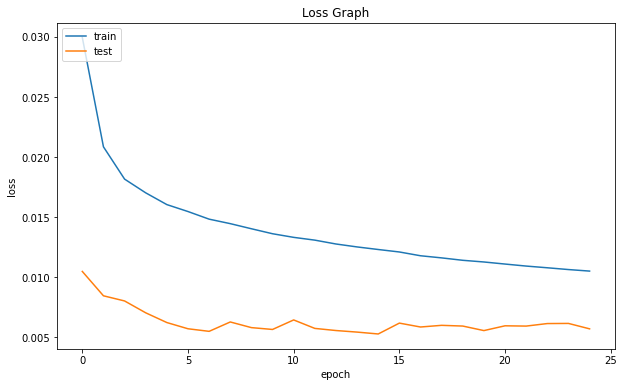

In [244]:
# Plot the loss 
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title('Loss Graph')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [245]:
pred_e2d2=model_e2d2.predict(X_test)

In [246]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [247]:
cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)','PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)','PT08.S5(O3)', 'T', 'RH', 'AH']
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(pred_e2d2)),columns=[cols])
tst = pd.DataFrame(index=range(0,len(pred_e2d2)),columns=[cols])
for k in range(len(pred_e2d2)):
    p = pred_e2d2[k]
    p1 = y_test[k]
    for j in range(0, pred_e2d2[k].shape[1]):
        for i in range(0, pred_e2d2[k].shape[0]):
           pred.iloc[k][j] = p[i][j]
           tst.iloc[k][j] = p1[i][j]

#check rmse
j = 0
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_absolute_error(pred.iloc[:,j], tst.iloc[:,j])))
    j +=1

rmse value for CO(GT) is :  2.946465301149107
rmse value for PT08.S1(CO) is :  9.406576031557988
rmse value for NMHC(GT) is :  3.1019596488449808
rmse value for C6H6(GT) is :  1.9661898791039167
rmse value for PT08.S2(NMHC) is :  10.635317731207742
rmse value for NOx(GT) is :  9.164628074932729
rmse value for PT08.S3(NOx) is :  9.932545698752552
rmse value for NO2(GT) is :  5.426479520355997
rmse value for PT08.S4(NO2) is :  10.944755292180378
rmse value for PT08.S5(O3) is :  13.594535572298128
rmse value for T is :  2.0557052764338706
rmse value for RH is :  2.919398978106424
rmse value for AH is :  1.1845951807986206
